In [1]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from core.utils.func_lib import *
from core.utils.GAN_utils import upconvGAN
from core.utils.GAN_utils import loadBigGAN, BigGAN_wrapper
from core.utils.GAN_invert_utils import *
from core.utils.GAN_utils import upconvGAN
from pytorch_pretrained_biggan import truncated_noise_sample
from torchvision.transforms import ToPILImage, PILToTensor, ToTensor
import numpy as np
import torch
import pandas as pd
from PIL import Image
from core.utils.image_similarity import *

In [2]:
data_root = r'C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data\gan_inversion\inverted\gan_inversion_results_fc6'


In [3]:
def read_data_in_pd(parent_path):
    # let read the all the files in the batched and save them in a single pd
    data_pd = pd.DataFrame(columns = ['file_name', 'iverted_code', 'inverted_image', 'orginal_image', 'inverted_code_path', 'inverted_image_path', 'orginal_image_path'])
    # let list all the files in the data_root and it subfolders
    all_files = [ os.path.join(dp, f) for dp, dn, fn in os.walk(parent_path) for f in fn]
    code_files = np.array([f for f in all_files if '_code.npy' in f])
    inverted_image_files = np.array([f for f in all_files if '_inverted.png' in f])
    orginal_image_files = np.array([f for f in all_files if '_original.png' in f])

    for fi in range(len(code_files)):
        # let get the file name
        file_name = os.path.basename(code_files[fi])
        file_name = '_'.join(file_name.split('.')[:-1][0].split('_')[:-1])
        # let read the code
        code = np.load(code_files[fi])
        # let read the inverted image
        inverted_image = ToTensor()(Image.open(inverted_image_files[fi]))
        # let read the orginal image
        orginal_image = ToTensor()(Image.open(orginal_image_files[fi]))
        # let save the data in the pd
        data_pd.loc[fi] = [file_name, code, inverted_image, orginal_image, code_files[fi], orginal_image_files[fi], orginal_image_files[fi]]
    return data_pd

init_counter_part_root = os.path.join(data_root, 'non_monkey')
init_counter_part_pd = read_data_in_pd(init_counter_part_root)

init_part_root = os.path.join(data_root, 'monkey')
init_part_pd = read_data_in_pd(init_part_root)




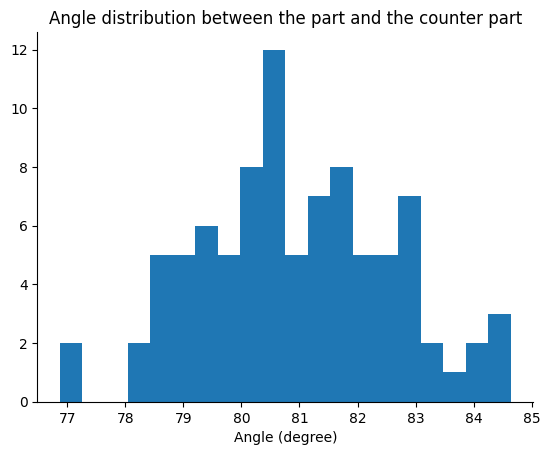

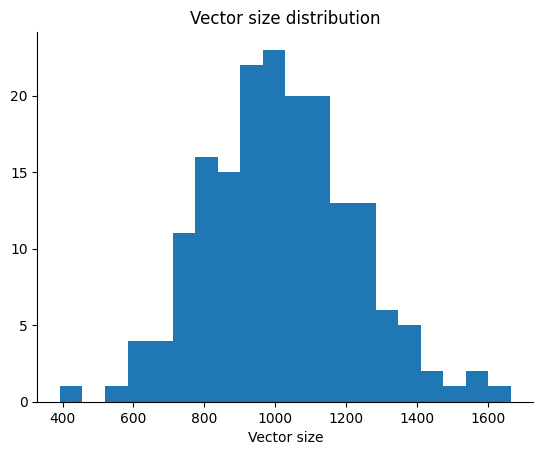

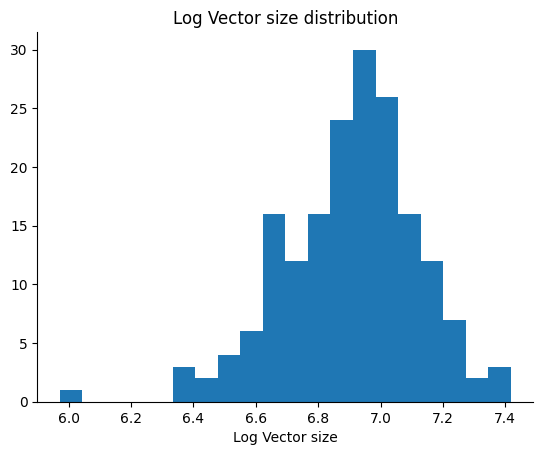

In [4]:
# let have sence of the distribution of the angles between the part and the counter part
angle_set = []
vecor_size_set = []
for i in range(len(init_part_pd)):
    code_part = init_part_pd['iverted_code'][i]
    code_counter_part = init_counter_part_pd['iverted_code'][i]
    #  lets get the code_part and code_counter_parr angle
    angle_part = np.arccos(np.dot(code_part, code_counter_part)/(np.linalg.norm(code_part)*np.linalg.norm(code_counter_part)))
    vecor_size_part = np.linalg.norm(code_part)
    vecor_size_counter_part = np.linalg.norm(code_counter_part)
    angle_set.append(angle_part)
    vecor_size_set.extend([vecor_size_part, vecor_size_counter_part])
angle_set = np.array(angle_set)
# convert the angle set to degree
angle_set = np.rad2deg(angle_set)
# let plit the angel distribution
plt.hist(angle_set, bins=20)
plt.title('Angle distribution between the part and the counter part')
plt.xlabel('Angle (degree)')
plt.show()

vecor_size_set = np.array(vecor_size_set)
# let plit the angel distribution
plt.hist(vecor_size_set, bins=20)
plt.title('Vector size distribution')
plt.xlabel('Vector size')
plt.show()

# let's get the distribuation of the ln of the 
vector_size_set_ln = np.log(vecor_size_set)
# let plit the angel distribution
plt.hist(vector_size_set_ln, bins=20)
plt.title('Log Vector size distribution')
plt.xlabel('Log Vector size')
plt.show()

In [5]:
# let save all ivereted images in a single folder witgh part and counterpart subfolders
save_root = r'C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data\gan_inversion\data_set_to_exp'
part_path = os.path.join(save_root, 'exp1_all_inverted_images', 'part')
counter_part_path = os.path.join(save_root, 'exp1_all_inverted_images', 'counterpart')
os.makedirs(part_path, exist_ok=True)
os.makedirs(counter_part_path, exist_ok=True)

new_name_map_part = {}
for i in range(len(init_part_pd)):
    file_name = (init_part_pd['file_name'][i])
    new_name = f'monkey_{i}'
    inverted_image = ToPILImage()(init_part_pd['inverted_image'][i])
    inverted_image.save(os.path.join(part_path, new_name + '.png'))
    new_name_map_part[new_name] = file_name
# let save the mapping in the same folder as dictionary
# convert the dictionary to a numpy array
new_name_map_part_numpy = np.array(list(new_name_map_part.items()))
np.save(os.path.join(part_path, 'name_map.npy'), new_name_map_part_numpy)
new_name_map_counter_part = {}
for i in range(len(init_counter_part_pd)):
    file_name = (init_counter_part_pd['file_name'][i])
    new_name = f'nonmonkey_{i}'
    inverted_image = ToPILImage()(init_counter_part_pd['inverted_image'][i])
    inverted_image.save(os.path.join(counter_part_path, new_name + '.png'))
    new_name_map_counter_part[new_name] = file_name
# let save the mapping in the same folder as dictionary
# convert the dictionary to a numpy array
new_name_map_counter_part_numpy = np.array(list(new_name_map_counter_part.items()))
np.save(os.path.join(counter_part_path, 'name_map.npy'), new_name_map_counter_part_numpy)

In [6]:
# Inb this session we will do the linear morphing between the part and counterpart images
# know we get all the images in the part pd and then morphe them to the counterpart coresponding
G = upconvGAN('fc6').cuda().eval()
save_root_linear = r'C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data\gan_inversion\data_set_to_exp\linear_morphing'
morph_path = os.path.join(save_root_linear, 'morphed_images_part_to_counterpart')
os.makedirs(morph_path, exist_ok=True)
k = 5
# let loop over the part images and morph them to the counterpart
name_map_morph = {}
for i in range(len(init_part_pd)):
    file_name_part = (init_part_pd['file_name'][i])
    file_name_counter_part = (init_counter_part_pd['file_name'][i])
    new_name = f'morphed_{i}'
    # let load the codes for the part and counter part
    code_part = init_part_pd['iverted_code'][i]
    code_counter_part = init_counter_part_pd['iverted_code'][i]
    # let morph the part to the counter part
    direction_code = code_counter_part - code_part
    interpolated_codes = []
    interpolated_code_names = []
    for i in range(k+1):
        new_code = code_part + (direction_code/k)*i
        interpolated_codes.append(new_code)
        interpolated_code_names.append(f"{new_name}_level_{i}")
    # covert the new code to tensor
    interpolated_codes = [torch.tensor(new_code).squeeze().cuda().float() for new_code in interpolated_codes]
    interpolated_codes = torch.stack(interpolated_codes)
    img_opt = G.visualize(interpolated_codes)
    for mp_i, mp_img in enumerate(img_opt):
        mp_img = ToPILImage()(mp_img)
        mp_img.save(os.path.join(morph_path, f"{interpolated_code_names[mp_i]}.png"))
    name_map_morph[new_name] = [file_name_part, file_name_counter_part]
# let save the mapping in the same folder as dictionary
# convert the dictionary to a numpy array
name_map_morph_numpy = np.array(list(name_map_morph.items()))
np.save(os.path.join(morph_path, 'name_map.npy'), name_map_morph_numpy)


part_path = os.path.join(save_root_linear, 'C1-1_C2-22', 'part')
counter_part_path = os.path.join(save_root_linear, 'C1-1_C2-22', 'counterpart')
os.makedirs(part_path, exist_ok=True)
os.makedirs(counter_part_path, exist_ok=True)

k = 5
# let loop over the part images and morph them to the counterpart
name_map_morph = {}
for i in range(len(init_part_pd)):
    file_name_part = (init_part_pd['file_name'][i])
    file_name_counter_part = (init_counter_part_pd['file_name'][i])
    code_part = init_part_pd['iverted_code'][i]    
    code_counter_part = init_counter_part_pd['iverted_code'][i]
    new_name_part = f'monkeymorphed_{i}'
    new_name_counter_part = f'nonmonkey_{i}'
    direction_code = code_counter_part - code_part
    mf = np.remainder(i, k-1) + 1
    new_code = code_part + (direction_code/k)*mf
    # covert the new code to tensor
    new_code = torch.tensor(new_code).squeeze().cuda().float()
    code_counter_part = torch.tensor(code_counter_part).squeeze().cuda().float()
    part_img = G.visualize(new_code)
    counterpart_img = G.visualize(code_counter_part)
    # save the images
    part_img = ToPILImage()(part_img[0])
    part_img.save(os.path.join(part_path, f"{new_name_part}.png"))
    counterpart_img = ToPILImage()(counterpart_img[0])
    counterpart_img.save(os.path.join(counter_part_path, f"{new_name_counter_part}.png"))
    name_map_morph[new_name_part, new_name_counter_part] = [file_name_part, file_name_counter_part]
# let save the mapping in the same folder as dictionary
# convert the dictionary to a numpy array
name_map_morph_numpy = np.array(list(name_map_morph.items()))
np.save(os.path.join(part_path, 'name_map.npy'), name_map_morph_numpy)

part_path = os.path.join(save_root_linear, 'C1-1_C2-21', 'part')
counter_part_path = os.path.join(save_root_linear, 'C1-1_C2-21', 'counterpart')
os.makedirs(part_path, exist_ok=True)
os.makedirs(counter_part_path, exist_ok=True)

k = 5
# let loop over the part images and morph them to the counterpart
name_map_morph = {}
for i in range(len(init_part_pd)):
    file_name_part = (init_part_pd['file_name'][i])
    file_name_counter_part = (init_counter_part_pd['file_name'][i])
    code_part = init_part_pd['iverted_code'][i]    
    code_counter_part = init_counter_part_pd['iverted_code'][i]
    new_name_part = f'monkey_{i}'
    new_name_counter_part = f'nonmonkeymorphed_{i}'
    direction_code = code_part - code_counter_part
    mf = np.remainder(i, k-1) + 1
    new_code = code_counter_part + (direction_code/k)*mf
    # covert the new code to tensor
    new_code = torch.tensor(new_code).squeeze().cuda().float()
    code_part = torch.tensor(code_part).squeeze().cuda().float()
    counterpart_img = G.visualize(new_code)
    part_img = G.visualize(code_part)
    # save the images
    part_img = ToPILImage()(part_img[0])
    part_img.save(os.path.join(part_path, f"{new_name_part}.png"))
    counterpart_img = ToPILImage()(counterpart_img[0])
    counterpart_img.save(os.path.join(counter_part_path, f"{new_name_counter_part}.png"))
    name_map_morph[new_name_part, new_name_counter_part] = [file_name_part, file_name_counter_part]
# let save the mapping in the same folder as dictionary
# convert the dictionary to a numpy array
name_map_morph_numpy = np.array(list(name_map_morph.items()))
np.save(os.path.join(part_path, 'name_map.npy'), name_map_morph_numpy)



C:\Users\Alireza\AppData\Local\Temp\ipykernel_30528\529534810.py:35: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  name_map_morph_numpy = np.array(list(name_map_morph.items()))


In [7]:
# know we get all the images in the part pd and then morphe them to the counterpart coresponding linearly in exp levels 
G = upconvGAN('fc6').cuda().eval()
part_image_distancer = TorchImageDistance()
counterpart_imgae_distancer = TorchImageDistance()

save_root_exp_levels = r'C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data\gan_inversion\data_set_to_exp\linear_morphing_in_exponatial_level'
morph_path = os.path.join(save_root_exp_levels, 'morphed_images_part_to_counterpart')
os.makedirs(morph_path, exist_ok=True)

part_path_c11c222 = os.path.join(save_root_exp_levels, 'C1-1_C2-22', 'part')
counter_part_path_c11c222 = os.path.join(save_root_exp_levels, 'C1-1_C2-22', 'counterpart')
os.makedirs(part_path_c11c222, exist_ok=True)
os.makedirs(counter_part_path_c11c222, exist_ok=True)

part_path_c11c221 = os.path.join(save_root_exp_levels, 'C1-1_C2-21', 'part')
counter_part_path_c11c221 = os.path.join(save_root_exp_levels, 'C1-1_C2-21', 'counterpart')
os.makedirs(part_path_c11c221, exist_ok=True)
os.makedirs(counter_part_path_c11c221, exist_ok=True)


# let make some list for save the images distances
part_image_to_morhed_distance_cnn_set = []
counterpart_image_to_morhed_distance_cnn_set = []
part_image_to_morhed_distance_lpips_set = []
counterpart_image_to_morhed_distance_lpips_set = []

k = 4
min_exp_level = np.log(300)

# let loop over the part images and morph them to the counterpart
name_map_morph = {}
for i in range(len(init_part_pd)):
    file_name_part = (init_part_pd['file_name'][i])
    file_name_counter_part = (init_counter_part_pd['file_name'][i])
    new_name = f'morphed_{i}'
    # let load the codes for the part and counter part
    code_part = init_part_pd['iverted_code'][i]
    code_counter_part = init_counter_part_pd['iverted_code'][i]
    # let get the part and counterpart orginal images
    part_img = init_part_pd['orginal_image'][i]
    counter_part_img = init_counter_part_pd['orginal_image'][i]
    # let morph the part to the counter part
    direction_code = code_counter_part - code_part
    interpolated_codes = []
    interpolated_code_names = []
    # let get the half the k points
    kh = int(k/2)
    code_part_exp_level = np.log(np.linalg.norm(code_part))
    code_counter_part_exp_level = np.log(np.linalg.norm(code_counter_part))

    for ii in range(k+2):
        new_code = code_part + (direction_code/(k+1))*ii
        interpolated_codes.append(new_code)
        morhped_name = f"{new_name}_level_{ii}"
        interpolated_code_names.append(morhped_name)
        name_map_morph[morhped_name] = [file_name_part, file_name_counter_part]

    c = 0
    decending_exp_step = (code_part_exp_level - min_exp_level)/(kh)
    for ii in range(kh+1):
        new_code = interpolated_codes[c]
        new_code = new_code/np.linalg.norm(new_code)*np.exp(code_part_exp_level - decending_exp_step*ii)
        interpolated_codes[c] = new_code
        c = c + 1
    if k%2 != 0:
        new_code = interpolated_codes[c]
        new_code = new_code/np.linalg.norm(new_code)*np.exp(min_exp_level)
        interpolated_codes[c] = new_code
        c = c + 1
    acending_exp_step = (code_counter_part_exp_level - min_exp_level)/(kh)
    for ii in range(kh+1):
        new_code = interpolated_codes[c]
        new_code = new_code/np.linalg.norm(new_code)*np.exp(min_exp_level + acending_exp_step*ii)
        interpolated_codes[c] = new_code
        c = c + 1
    # covert the new code to tensor
    interpolated_codes = [torch.tensor(new_code).squeeze().cuda().float() for new_code in interpolated_codes]
    interpolated_codes = torch.stack(interpolated_codes)
    img_opt = G.visualize(interpolated_codes)
    # img_opt[0] is a the part image and img_opt[-1] is the counter part images we want two tensor of the these two images repitation with the same size of the img_opt tensor
    part_img_tensor = part_img.repeat(img_opt.size(0), 1, 1, 1)  
    counter_part_img_tensor = counter_part_img.repeat(img_opt.size(0), 1, 1, 1)
    # let get the distance between the part and the counter part
    part_image_distancer.set_first_image_batch(part_img_tensor)
    counterpart_imgae_distancer.set_first_image_batch(counter_part_img_tensor)

    part_image_distancer.set_second_image_batch(img_opt)
    counterpart_imgae_distancer.set_second_image_batch(img_opt)

    part_image_to_morhed_distance_cnn, _ = part_image_distancer.get_CCN_distance(units_slice='all')
    counterpart_image_to_morhed_distance_cnn, _ = counterpart_imgae_distancer.get_CCN_distance(units_slice='all')

    part_image_to_morhed_distance_lpips = part_image_distancer.get_LPIPS_distance()
    counterpart_image_to_morhed_distance_lpips = counterpart_imgae_distancer.get_LPIPS_distance()

    part_image_to_morhed_distance_cnn_set.append(part_image_to_morhed_distance_cnn)
    counterpart_image_to_morhed_distance_cnn_set.append(counterpart_image_to_morhed_distance_cnn)
    part_image_to_morhed_distance_lpips_set.append(part_image_to_morhed_distance_lpips)
    counterpart_image_to_morhed_distance_lpips_set.append(counterpart_image_to_morhed_distance_lpips)

    # Let save the images
    for mp_i, mp_img in enumerate(img_opt):
        mp_img = ToPILImage()(mp_img)
        mp_img.save(os.path.join(morph_path, f"{interpolated_code_names[mp_i]}.png"))
        
    img_opt_plt = [ToPILImage()(mp_img) for mp_img in img_opt]
    ip = mf = np.remainder(i, k)
    img_opt_plt[ip+1].save(os.path.join(part_path_c11c222, f"{interpolated_code_names[ip+1]}.png"))
    img_opt_plt[-1].save(os.path.join(counter_part_path_c11c222, f"{interpolated_code_names[-1]}.png"))

    icp = mf = np.remainder(i, k)
    img_opt_plt[0].save(os.path.join(part_path_c11c221, f"{interpolated_code_names[0]}.png"))
    img_opt_plt[icp+1].save(os.path.join(counter_part_path_c11c221, f"{interpolated_code_names[icp+1]}.png"))
# let save the mapping in the same folder as dictionary
# convert the dictionary to a numpy array
name_map_morph_numpy = np.array(list(name_map_morph.items()))
np.save(os.path.join(part_path_c11c222, 'name_map.npy'), name_map_morph_numpy)
np.save(os.path.join(part_path_c11c221, 'name_map.npy'), name_map_morph_numpy)
np.save(os.path.join(morph_path, 'name_map.npy'), name_map_morph_numpy)
counterpart_imgae_distancer.memory_cleanup()
part_image_distancer.memory_cleanup()

c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You ca

The CNN scorers are set


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You ca

The CNN scorers are set
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.


C:\Users\Alireza\AppData\Local\Temp\ipykernel_30528\499104242.py:116: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  name_map_morph_numpy = np.array(list(name_map_morph.items()))


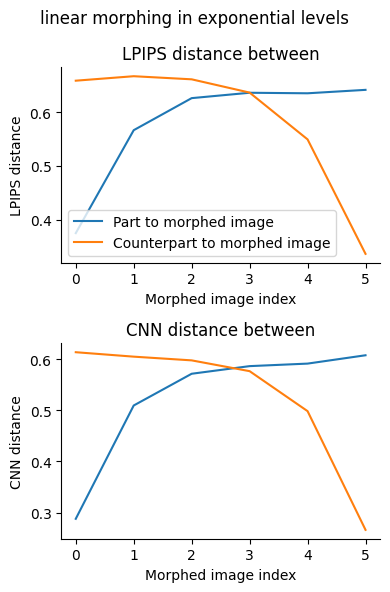

In [8]:
# let concatenate the distances to get a N*(k+2) matrix
part_image_to_morhed_distance_lpips_tensor = torch.stack(part_image_to_morhed_distance_lpips_set)
counterpart_image_to_morhed_distance_lpips_tensor = torch.stack(counterpart_image_to_morhed_distance_lpips_set)
part_image_to_morhed_distance_cnn_tensor = np.array(part_image_to_morhed_distance_cnn_set)
counterpart_image_to_morhed_distance_cnn_tensor = np.array(counterpart_image_to_morhed_distance_cnn_set)

# let plot the distances for the both distances part in the left and counterpart in the right y axis and one panel for each distance
fig, ax = plt.subplots(2, 1, figsize=(4, 6))
ax[0].plot(part_image_to_morhed_distance_lpips_tensor.mean(axis=0), label='Part to morphed image')
ax[0].plot(counterpart_image_to_morhed_distance_lpips_tensor.mean(axis=0), label='Counterpart to morphed image')
ax[0].set_title('LPIPS distance between')
ax[0].set_xlabel('Morphed image index')
ax[0].set_ylabel('LPIPS distance')
ax[0].legend()
ax[1].plot(part_image_to_morhed_distance_cnn_tensor.mean(axis=0), label='Part to morphed image')
ax[1].plot(counterpart_image_to_morhed_distance_cnn_tensor.mean(axis=0), label='Counterpart to morphed image')
ax[1].set_title('CNN distance between')
ax[1].set_xlabel('Morphed image index')
ax[1].set_ylabel('CNN distance')
# add atitle for the whole figure
fig.suptitle('linear morphing in exponential levels')
plt.tight_layout()
plt.show()

In [9]:
# know we get all the images in the part pd and then morphe them to the counterpart coresponding exponatialy in exponatioal levels 
G = upconvGAN('fc6').cuda().eval()
#part_image_distancer = TorchImageDistance()
#counterpart_imgae_distancer = TorchImageDistance()

save_root_exp_levels = r'C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data\gan_inversion\data_set_to_exp\exponatioal_morphing_in_exponatial_level'
morph_path = os.path.join(save_root_exp_levels, 'morphed_images_part_to_counterpart')
os.makedirs(morph_path, exist_ok=True)

part_path_c11c222 = os.path.join(save_root_exp_levels, 'C1-1_C2-22', 'part')
counter_part_path_c11c222 = os.path.join(save_root_exp_levels, 'C1-1_C2-22', 'counterpart')
os.makedirs(part_path_c11c222, exist_ok=True)
os.makedirs(counter_part_path_c11c222, exist_ok=True)

part_path_c11c221 = os.path.join(save_root_exp_levels, 'C1-1_C2-21', 'part')
counter_part_path_c11c221 = os.path.join(save_root_exp_levels, 'C1-1_C2-21', 'counterpart')
os.makedirs(part_path_c11c221, exist_ok=True)
os.makedirs(counter_part_path_c11c221, exist_ok=True)


k = 4
# give me k expontail spaced level between the 0 to 1 (and add the 0 and 1 to the list)
levels = np.logspace(0, 1, num=k+2, base=15) - 1
levels = levels /  levels.max() # Normalize to the range [0, 1]
min_exp_level = np.log(300)

# let make some list for save the images distances
part_image_to_morhed_distance_cnn_set = []
counterpart_image_to_morhed_distance_cnn_set = []
part_image_to_morhed_distance_lpips_set = []
counterpart_image_to_morhed_distance_lpips_set = []


# let loop over the part images and morph them to the counterpart
name_map_morph = {}
for i in range(len(init_part_pd)):
    file_name_part = (init_part_pd['file_name'][i])
    file_name_counter_part = (init_counter_part_pd['file_name'][i])
    new_name = f'morphed_{i}'
    # let load the codes for the part and counter part
    code_part = init_part_pd['iverted_code'][i]
    code_counter_part = init_counter_part_pd['iverted_code'][i]
    # let get the part and counterpart orginal images
    part_img = init_part_pd['orginal_image'][i]
    counter_part_img = init_counter_part_pd['orginal_image'][i]
    # let morph the part to the counter part
    direction_code = code_counter_part - code_part
    interpolated_codes = []
    interpolated_code_names = []
    # let get the half the k points
    kh = int(k/2)
    code_part_exp_level = np.log(np.linalg.norm(code_part))
    code_counter_part_exp_level = np.log(np.linalg.norm(code_counter_part))

    for ii in range(k+2):
        new_code = code_part + (direction_code*levels[ii])
        interpolated_codes.append(new_code)
        morhped_name = f"{new_name}_level_{ii}"
        interpolated_code_names.append(morhped_name)
        name_map_morph[morhped_name] = [file_name_part, file_name_counter_part]

    decending_exp_step = (code_part_exp_level - min_exp_level)
    acending_exp_step = (code_counter_part_exp_level - min_exp_level)
    for ii in range(k+2):
        new_code = interpolated_codes[ii]
        exp_level = .5 - levels[ii]
        if exp_level > 0:
            decending_factor = np.abs(exp_level)/.5
            new_code = new_code/np.linalg.norm(new_code)*np.exp(min_exp_level + decending_exp_step*decending_factor)
        else:
            acending_factor = np.abs(exp_level)/.5
            new_code = new_code/np.linalg.norm(new_code)*np.exp(min_exp_level + acending_exp_step*acending_factor)
        interpolated_codes[ii] = new_code

    # covert the new code to tensor
    interpolated_codes = [torch.tensor(new_code).squeeze().cuda().float() for new_code in interpolated_codes]
    interpolated_codes = torch.stack(interpolated_codes)
    img_opt = G.visualize(interpolated_codes)

    # img_opt[0] is a the part image and img_opt[-1] is the counter part images we want two tensor of the these two images repitation with the same size of the img_opt tensor
    part_img_tensor = part_img.repeat(img_opt.size(0), 1, 1, 1)  
    counter_part_img_tensor = counter_part_img.repeat(img_opt.size(0), 1, 1, 1)
    # let get the distance between the part and the counter part
    '''part_image_distancer.set_first_image_batch(part_img_tensor)
    counterpart_imgae_distancer.set_first_image_batch(counter_part_img_tensor)

    part_image_distancer.set_second_image_batch(img_opt)
    counterpart_imgae_distancer.set_second_image_batch(img_opt)

    part_image_to_morhed_distance_cnn, _ = part_image_distancer.get_CCN_distance(units_slice='all')
    counterpart_image_to_morhed_distance_cnn, _ = counterpart_imgae_distancer.get_CCN_distance(units_slice='all')

    part_image_to_morhed_distance_lpips = part_image_distancer.get_LPIPS_distance()
    counterpart_image_to_morhed_distance_lpips = counterpart_imgae_distancer.get_LPIPS_distance()

    part_image_to_morhed_distance_cnn_set.append(part_image_to_morhed_distance_cnn)
    counterpart_image_to_morhed_distance_cnn_set.append(counterpart_image_to_morhed_distance_cnn)
    part_image_to_morhed_distance_lpips_set.append(part_image_to_morhed_distance_lpips)
    counterpart_image_to_morhed_distance_lpips_set.append(counterpart_image_to_morhed_distance_lpips)'''
    
    # Let save the images
    for mp_i, mp_img in enumerate(img_opt):
        mp_img = ToPILImage()(mp_img)
        mp_img.save(os.path.join(morph_path, f"{interpolated_code_names[mp_i]}.png"))
        
    img_opt_plt = [ToPILImage()(mp_img) for mp_img in img_opt]
    ip = mf = np.remainder(i, k)
    img_opt_plt[ip+1].save(os.path.join(part_path_c11c222, f"{interpolated_code_names[ip+1]}.png"))
    img_opt_plt[-1].save(os.path.join(counter_part_path_c11c222, f"{interpolated_code_names[-1]}.png"))

    icp = mf = np.remainder(i, k)
    img_opt_plt[0].save(os.path.join(part_path_c11c221, f"{interpolated_code_names[0]}.png"))
    img_opt_plt[icp+1].save(os.path.join(counter_part_path_c11c221, f"{interpolated_code_names[icp+1]}.png"))
# let save the mapping in the same folder as dictionary
# convert the dictionary to a numpy array
name_map_morph_numpy = np.array(list(name_map_morph.items()))
np.save(os.path.join(part_path_c11c222, 'name_map.npy'), name_map_morph_numpy)
np.save(os.path.join(part_path_c11c221, 'name_map.npy'), name_map_morph_numpy)
np.save(os.path.join(morph_path, 'name_map.npy'), name_map_morph_numpy)

#counterpart_imgae_distancer.memory_cleanup()
#part_image_distancer.memory_cleanup()

c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


The CNN scorers are set


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You ca

The CNN scorers are set
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth


KeyboardInterrupt: 

In [44]:
''''
# let concatenate the distances to get a N*(k+2) matrix
part_image_to_morhed_distance_lpips_tensor = torch.stack(part_image_to_morhed_distance_lpips_set)
counterpart_image_to_morhed_distance_lpips_tensor = torch.stack(counterpart_image_to_morhed_distance_lpips_set)
part_image_to_morhed_distance_cnn_tensor = np.array(part_image_to_morhed_distance_cnn_set)
counterpart_image_to_morhed_distance_cnn_tensor = np.array(counterpart_image_to_morhed_distance_cnn_set)

# let plot the distances for the both distances part in the left and counterpart in the right y axis and one panel for each distance
fig, ax = plt.subplots(2, 1, figsize=(4, 6))
ax[0].plot(part_image_to_morhed_distance_lpips_tensor.mean(axis=0), label='Part to morphed image')
ax[0].plot(counterpart_image_to_morhed_distance_lpips_tensor.mean(axis=0), label='Counterpart to morphed image')
ax[0].set_title('LPIPS distance between')
ax[0].set_xlabel('Morphed image index')
ax[0].set_ylabel('LPIPS distance')
ax[0].legend()
ax[1].plot(part_image_to_morhed_distance_cnn_tensor.mean(axis=0), label='Part to morphed image')
ax[1].plot(counterpart_image_to_morhed_distance_cnn_tensor.mean(axis=0), label='Counterpart to morphed image')
ax[1].set_title('CNN distance between')
ax[1].set_xlabel('Morphed image index')
ax[1].set_ylabel('CNN distance')
# add atitle for the whole figure
fig.suptitle('eponential morphing in exponential levels')
plt.tight_layout()
plt.show()
'''

SyntaxError: incomplete input (3434201368.py, line 1)

In [46]:
# know we get all the images in the part pd and then morphe them to the counterpart coresponding exponatialy in exponatioal levels for saving the images
G = upconvGAN('fc6').cuda().eval()

k = 4
# let have a landa the base that is the expontial base of 2, 4, 8, 16, 32, 64
lambda_set = np.array([2**i for i in np.arange(1, 7)])
min_exp_level = np.log(300)

for lmb in lambda_set:

    
    save_root_exp_levels = rf'C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data\gan_inversion\data_set_to_exp\exponatioal_morphing_in_exponatial_level_base_{lmb}'
    morph_path = os.path.join(save_root_exp_levels, 'morphed_images_part_to_counterpart')
    os.makedirs(morph_path, exist_ok=True)

    part_path_c11c222 = os.path.join(save_root_exp_levels, 'C1-1_C2-22', 'part')
    counter_part_path_c11c222 = os.path.join(save_root_exp_levels, 'C1-1_C2-22', 'counterpart')
    os.makedirs(part_path_c11c222, exist_ok=True)
    os.makedirs(counter_part_path_c11c222, exist_ok=True)

    part_path_c11c221 = os.path.join(save_root_exp_levels, 'C1-1_C2-21', 'part')
    counter_part_path_c11c221 = os.path.join(save_root_exp_levels, 'C1-1_C2-21', 'counterpart')
    os.makedirs(part_path_c11c221, exist_ok=True)
    os.makedirs(counter_part_path_c11c221, exist_ok=True)

    # give me k expontail spaced level between the 0 to 1 (and add the 0 and 1 to the list)
    levels = np.logspace(0, 1, num=k+2, base=lmb) - 1
    levels = levels /  levels.max() # Normalize to the range [0, 1]

    name_map_morph = {}

    # let loop over the part images and morph them to the counterpart
    for i in range(len(init_part_pd)):
        file_name_part = (init_part_pd['file_name'][i])
        file_name_counter_part = (init_counter_part_pd['file_name'][i])
        new_name = f'morphed_{i}'
        # let load the codes for the part and counter part
        code_part = init_part_pd['iverted_code'][i]
        code_counter_part = init_counter_part_pd['iverted_code'][i]
        # let get the part and counterpart orginal images
        part_img = init_part_pd['orginal_image'][i]
        counter_part_img = init_counter_part_pd['orginal_image'][i]
        # let morph the part to the counter part
        direction_code = code_counter_part - code_part
        interpolated_codes = []
        interpolated_code_names = []
        # let get the half the k points
        kh = int(k/2)
        code_part_exp_level = np.log(np.linalg.norm(code_part))
        code_counter_part_exp_level = np.log(np.linalg.norm(code_counter_part))

        for ii in range(k+2):
            new_code = code_part + (direction_code*levels[ii])
            interpolated_codes.append(new_code)
            morhped_name = f"{new_name}_level_{ii}"
            interpolated_code_names.append(morhped_name)

        decending_exp_step = (code_part_exp_level - min_exp_level)
        acending_exp_step = (code_counter_part_exp_level - min_exp_level)
        for ii in range(k+2):
            new_code = interpolated_codes[ii]
            exp_level = .5 - levels[ii]
            if exp_level > 0:
                decending_factor = np.abs(exp_level)/.5
                new_code = new_code/np.linalg.norm(new_code)*np.exp(min_exp_level + decending_exp_step*decending_factor)
            else:
                acending_factor = np.abs(exp_level)/.5
                new_code = new_code/np.linalg.norm(new_code)*np.exp(min_exp_level + acending_exp_step*acending_factor)
            interpolated_codes[ii] = new_code

        # covert the new code to tensor
        interpolated_codes = [torch.tensor(new_code).squeeze().cuda().float() for new_code in interpolated_codes]
        interpolated_codes = torch.stack(interpolated_codes)
        img_opt = G.visualize(interpolated_codes)

         # Let save the images
        for mp_i, mp_img in enumerate(img_opt):
            mp_img = ToPILImage()(mp_img)
            mp_img.save(os.path.join(morph_path, f"{interpolated_code_names[mp_i]}.png"))
            
        img_opt_plt = [ToPILImage()(mp_img) for mp_img in img_opt]
        ip = mf = np.remainder(i, k)
        img_opt_plt[ip+1].save(os.path.join(part_path_c11c222, f"{interpolated_code_names[ip+1]}.png"))
        img_opt_plt[-1].save(os.path.join(counter_part_path_c11c222, f"{interpolated_code_names[-1]}.png"))

        icp = mf = np.remainder(i, k)
        img_opt_plt[0].save(os.path.join(part_path_c11c221, f"{interpolated_code_names[0]}.png"))
        img_opt_plt[icp+1].save(os.path.join(counter_part_path_c11c221, f"{interpolated_code_names[icp+1]}.png"))
    # let save the mapping in the same folder as dictionary
    # convert the dictionary to a numpy array
    name_map_morph_numpy = np.array(list(name_map_morph.items()))
    np.save(os.path.join(part_path_c11c222, 'name_map.npy'), name_map_morph_numpy)
    np.save(os.path.join(part_path_c11c221, 'name_map.npy'), name_map_morph_numpy)
    np.save(os.path.join(morph_path, 'name_map.npy'), name_map_morph_numpy)
    

In [8]:
# know we get all the images in the part pd and then morphe them to the counterpart coresponding exponatialy in exponatioal levels forexxp base assay
G = upconvGAN('fc6').cuda().eval()
part_image_distancer = TorchImageDistance()
counterpart_imgae_distancer = TorchImageDistance()


k = 4
# let have a landa the base that is the expontial base of 2, 4, 8, 16, 32, 64
lambda_set = np.array([2**i for i in np.arange(1, 7)])
min_exp_level = np.log(300)

part_image_to_morhed_distance_cnn_diffrance_lambda = []
counterpart_image_to_morhed_distance_cnn_diffrance_lambda = []
part_image_to_morhed_distance_lpips_diffrance_lambda = []
counterpart_image_to_morhed_distance_lpips_diffrance_lambda = []

for lmb in lambda_set:

    # give me k expontail spaced level between the 0 to 1 (and add the 0 and 1 to the list)
    levels = np.logspace(0, 1, num=k+2, base=lmb) - 1
    levels = levels /  levels.max() # Normalize to the range [0, 1]

    # let make some list for save the images distances
    part_image_to_morhed_distance_cnn_set = []
    counterpart_image_to_morhed_distance_cnn_set = []
    part_image_to_morhed_distance_lpips_set = []
    counterpart_image_to_morhed_distance_lpips_set = []


    # let loop over the part images and morph them to the counterpart
    for i in range(len(init_part_pd)):
        file_name_part = (init_part_pd['file_name'][i])
        file_name_counter_part = (init_counter_part_pd['file_name'][i])
        new_name = f'morphed_{i}'
        # let load the codes for the part and counter part
        code_part = init_part_pd['iverted_code'][i]
        code_counter_part = init_counter_part_pd['iverted_code'][i]
        # let get the part and counterpart orginal images
        part_img = init_part_pd['orginal_image'][i]
        counter_part_img = init_counter_part_pd['orginal_image'][i]
        # let morph the part to the counter part
        direction_code = code_counter_part - code_part
        interpolated_codes = []
        interpolated_code_names = []
        # let get the half the k points
        kh = int(k/2)
        code_part_exp_level = np.log(np.linalg.norm(code_part))
        code_counter_part_exp_level = np.log(np.linalg.norm(code_counter_part))

        for ii in range(k+2):
            new_code = code_part + (direction_code*levels[ii])
            interpolated_codes.append(new_code)
            morhped_name = f"{new_name}_level_{ii}"
            interpolated_code_names.append(morhped_name)

        decending_exp_step = (code_part_exp_level - min_exp_level)
        acending_exp_step = (code_counter_part_exp_level - min_exp_level)
        for ii in range(k+2):
            new_code = interpolated_codes[ii]
            exp_level = .5 - levels[ii]
            if exp_level > 0:
                decending_factor = np.abs(exp_level)/.5
                new_code = new_code/np.linalg.norm(new_code)*np.exp(min_exp_level + decending_exp_step*decending_factor)
            else:
                acending_factor = np.abs(exp_level)/.5
                new_code = new_code/np.linalg.norm(new_code)*np.exp(min_exp_level + acending_exp_step*acending_factor)
            interpolated_codes[ii] = new_code

        # covert the new code to tensor
        interpolated_codes = [torch.tensor(new_code).squeeze().cuda().float() for new_code in interpolated_codes]
        interpolated_codes = torch.stack(interpolated_codes)
        img_opt = G.visualize(interpolated_codes)

        # img_opt[0] is a the part image and img_opt[-1] is the counter part images we want two tensor of the these two images repitation with the same size of the img_opt tensor
        part_img_tensor = part_img.repeat(img_opt.size(0), 1, 1, 1)  
        counter_part_img_tensor = counter_part_img.repeat(img_opt.size(0), 1, 1, 1)
        # let get the distance between the part and the counter part
        part_image_distancer.set_first_image_batch(part_img_tensor)
        counterpart_imgae_distancer.set_first_image_batch(counter_part_img_tensor)

        part_image_distancer.set_second_image_batch(img_opt)
        counterpart_imgae_distancer.set_second_image_batch(img_opt)

        part_image_to_morhed_distance_cnn, _ = part_image_distancer.get_CCN_distance(units_slice='all')
        counterpart_image_to_morhed_distance_cnn, _ = counterpart_imgae_distancer.get_CCN_distance(units_slice='all')

        part_image_to_morhed_distance_lpips = part_image_distancer.get_LPIPS_distance()
        counterpart_image_to_morhed_distance_lpips = counterpart_imgae_distancer.get_LPIPS_distance()

        
        part_image_to_morhed_distance_lpips_set.append(part_image_to_morhed_distance_lpips)
        counterpart_image_to_morhed_distance_lpips_set.append(counterpart_image_to_morhed_distance_lpips)
        part_image_to_morhed_distance_cnn_set.append(part_image_to_morhed_distance_cnn)
        counterpart_image_to_morhed_distance_cnn_set.append(counterpart_image_to_morhed_distance_cnn)

    # let concatenate the distances to get a N*(k+2) matrix
    part_image_to_morhed_distance_lpips_tensor = torch.stack(part_image_to_morhed_distance_lpips_set)
    counterpart_image_to_morhed_distance_lpips_tensor = torch.stack(counterpart_image_to_morhed_distance_lpips_set)
    part_image_to_morhed_distance_cnn_tensor = np.array(part_image_to_morhed_distance_cnn_set)
    counterpart_image_to_morhed_distance_cnn_tensor = np.array(counterpart_image_to_morhed_distance_cnn_set)

    part_image_to_morhed_distance_lpips_diffrance_lambda.append(part_image_to_morhed_distance_lpips_tensor)
    counterpart_image_to_morhed_distance_lpips_diffrance_lambda.append(counterpart_image_to_morhed_distance_lpips_tensor)
    part_image_to_morhed_distance_cnn_diffrance_lambda.append(part_image_to_morhed_distance_cnn_tensor)
    counterpart_image_to_morhed_distance_cnn_diffrance_lambda.append(counterpart_image_to_morhed_distance_cnn_tensor)

counterpart_imgae_distancer.memory_cleanup()
part_image_distancer.memory_cleanup()

c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You ca

The CNN scorers are set


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You ca

The CNN scorers are set
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: c:\Users\Alireza\miniconda3\envs\cosine-project\lib\site-packages\lpips\weights\v0.1\alex.pth
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.
Cleanuping...
Cleanup hooks done.
Cleanup done.


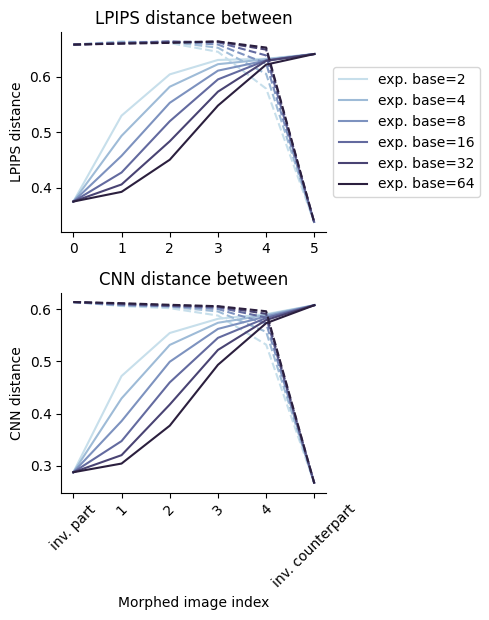

In [42]:
part_image_to_morhed_distance_lpips_diffrance_lambda_tensor = torch.stack(part_image_to_morhed_distance_lpips_diffrance_lambda)
counterpart_image_to_morhed_distance_lpips_diffrance_lambda_tensor = torch.stack(counterpart_image_to_morhed_distance_lpips_diffrance_lambda)
part_image_to_morhed_distance_cnn_diffrance_lambda_array = np.array(part_image_to_morhed_distance_cnn_diffrance_lambda)
counterpart_image_to_morhed_distance_cnn_diffrance_lambda_array = np.array(counterpart_image_to_morhed_distance_cnn_diffrance_lambda)

# let get palet of colors for a shage of the lambda using seaborn
import seaborn as sns
colors = sns.color_palette("ch:s=.25,rot=-.25", len(lambda_set)) # "flare", "Spectral"

fig, ax = plt.subplots(2, 1, figsize=(5, 6.3))
for i, lmb in enumerate(lambda_set):
    ax[0].plot(part_image_to_morhed_distance_lpips_diffrance_lambda_tensor[i].mean(axis=0), label=f'exp. base={lmb}', color=colors[i])
    ax[0].plot(counterpart_image_to_morhed_distance_lpips_diffrance_lambda_tensor[i].mean(axis=0), color=colors[i], linestyle='--')
    
    ax[1].plot(part_image_to_morhed_distance_cnn_diffrance_lambda_array[i].mean(axis=0), label=f'exp. base={lmb}', color=colors[i])
    ax[1].plot(counterpart_image_to_morhed_distance_cnn_diffrance_lambda_array[i].mean(axis=0), color=colors[i], linestyle='--')
ax[0].set_title('LPIPS distance between')
ax[1].set_xlabel('Morphed image index')
ax[0].set_ylabel('LPIPS distance')
ax[1].set_title('CNN distance between')
ax[1].set_ylabel('CNN distance')
# changed the x ticks to the [inv. part, 1, 2, 4, inv. counter part]
ax[1].set_xticks([0, 1, 2, 3, 4, 5])
ax[1].set_xticklabels(['inv. part', '1', '2', '3', '4', 'inv. counterpart'], rotation=45)
# set the legend outside the plot
ax[0].legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.show()





In [ ]:
# know we get all the images in the part pd and then morphe them to the counterpart coresponding exponatialy in exponatioal levels in random direction 
G = upconvGAN('fc6').cuda().eval()
save_root_exp_levels = r'C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data\gan_inversion\data_set_to_exp\random_direction_exponatioal_morphing_in_exponatial_level'
morph_path = os.path.join(save_root_exp_levels, 'morphed_images_part_to_counterpart')
os.makedirs(morph_path, exist_ok=True)

part_path_c11c222 = os.path.join(save_root_exp_levels, 'C1-1_C2-22', 'part')
counter_part_path_c11c222 = os.path.join(save_root_exp_levels, 'C1-1_C2-22', 'counterpart')
os.makedirs(part_path_c11c222, exist_ok=True)
os.makedirs(counter_part_path_c11c222, exist_ok=True)

part_path_c11c221 = os.path.join(save_root_exp_levels, 'C1-1_C2-21', 'part')
counter_part_path_c11c221 = os.path.join(save_root_exp_levels, 'C1-1_C2-21', 'counterpart')
os.makedirs(part_path_c11c221, exist_ok=True)
os.makedirs(counter_part_path_c11c221, exist_ok=True)


k = 4
# give me k expontail spaced level between the 0 to 1 (and add the 0 and 1 to the list)
levels = np.logspace(0, 1, num=k+2, base=10) - 1
levels = levels /  levels.max() # Normalize to the range [0, 1]

min_exp_level = np.log(300)

# let loop over the part images and morph them to the counterpart
name_map_morph = {}
for i in range(len(init_part_pd)):
    file_name_part = (init_part_pd['file_name'][i])
    file_name_counter_part = (init_counter_part_pd['file_name'][i])
    new_name = f'morphed_{i}'
    # let load the codes for the part and counter part
    code_part = init_part_pd['iverted_code'][i]
    code_counter_part = init_counter_part_pd['iverted_code'][i]
    # let morph the part to the counter part
    direction_p2cp_code = code_counter_part - code_part
    direction_cp2c_code = code_part - code_counter_part
    # let get the random with the same size as direction_p2cp_code by prmuting the direction_p2cp_code
    direction_p2cp_code = np.random.permutation(direction_p2cp_code)
    direction_cp2c_code = np.random.permutation(direction_cp2c_code)

    morphed_part_codes = []
    morphed_part_codes_names = []
    morphed_counterpart_codes = []
    morphed_counterpart_codes_names = []
    # let get the half the k points
    kh = int(k/2)
    code_part_exp_level = np.log(np.linalg.norm(code_part))
    code_counter_part_exp_level = np.log(np.linalg.norm(code_counter_part))

    for ii in range(k+2):
        new_code = code_part + (direction_code*levels[ii])
        interpolated_codes.append(new_code)
        morhped_name = f"{new_name}_level_{ii}"
        interpolated_code_names.append(morhped_name)
        name_map_morph[morhped_name] = [file_name_part, file_name_counter_part]

    decending_exp_step = (code_part_exp_level - min_exp_level)
    acending_exp_step = (code_counter_part_exp_level - min_exp_level)
    for ii in range(k+2):
        new_code = interpolated_codes[ii]
        exp_level = .5 - levels[ii]
        if exp_level > 0:
            decending_factor = np.abs(exp_level)/.5
            new_code = new_code/np.linalg.norm(new_code)*np.exp(min_exp_level + decending_exp_step*decending_factor)
        else:
            acending_factor = np.abs(exp_level)/.5
            new_code = new_code/np.linalg.norm(new_code)*np.exp(min_exp_level + acending_exp_step*acending_factor)
        interpolated_codes[ii] = new_code

    # covert the new code to tensor
    interpolated_codes = [torch.tensor(new_code).squeeze().cuda().float() for new_code in interpolated_codes]
    interpolated_codes = torch.stack(interpolated_codes)
    img_opt = G.visualize(interpolated_codes)
    for mp_i, mp_img in enumerate(img_opt):
        mp_img = ToPILImage()(mp_img)
        mp_img.save(os.path.join(morph_path, f"{interpolated_code_names[mp_i]}.png"))
        
    img_opt_plt = [ToPILImage()(mp_img) for mp_img in img_opt]
    ip = mf = np.remainder(i, k)
    img_opt_plt[ip+1].save(os.path.join(part_path_c11c222, f"{interpolated_code_names[ip+1]}.png"))
    img_opt_plt[-1].save(os.path.join(counter_part_path_c11c222, f"{interpolated_code_names[-1]}.png"))

    icp = mf = np.remainder(i, k)
    img_opt_plt[0].save(os.path.join(part_path_c11c221, f"{interpolated_code_names[0]}.png"))
    img_opt_plt[icp+1].save(os.path.join(counter_part_path_c11c221, f"{interpolated_code_names[icp+1]}.png"))
# let save the mapping in the same folder as dictionary
# convert the dictionary to a numpy array
name_map_morph_numpy = np.array(list(name_map_morph.items()))
np.save(os.path.join(part_path_c11c222, 'name_map.npy'), name_map_morph_numpy)
np.save(os.path.join(part_path_c11c221, 'name_map.npy'), name_map_morph_numpy)
np.save(os.path.join(morph_path, 'name_map.npy'), name_map_morph_numpy)

In [ ]:
# bunch of functions to randon sampling fron the hyper circle/ sphere/ arch
def find_circumcenter_regularized(i1, i2, i3, lambda_reg=1e-5):
    # Form the matrix A where each row is 2 * (ik - i1)
    A = 2 * np.array([i2 - i1, i3 - i1])
    # Form the vector b
    b = np.array([np.dot(i2, i2) - np.dot(i1, i1), np.dot(i3, i3) - np.dot(i1, i1)])
    
    # Apply Tikhonov regularization
    ATA = A.T @ A + lambda_reg * np.eye(A.shape[1])
    ATb = A.T @ b
    
    # Solve the regularized system
    r = np.linalg.solve(ATA, ATb)
    
    return r


def slerp(v0, v1, t):
    """ Perform spherical linear interpolation between two vectors """
    dot = np.dot(v0, v1)
    theta = np.arccos(dot)
    sin_theta = np.sin(theta)
    
    s0 = np.sin((1 - t) * theta) / sin_theta
    s1 = np.sin(t * theta) / sin_theta
    
    return s0 * v0 + s1 * v1

def equally_spaced_points_on_hypercircle(i1, i2, r, k):
    """
    Generate k equally spaced points on the hypercircle between points i1 and i2.
    
    Parameters:
    i1, i2, r (numpy arrays): coordinates of points i1, i2, and the center r
    k (int): number of equally spaced points to generate
    
    Returns:
    points (list of numpy arrays): list containing the k points
    """
    # Calculate normalized direction vectors
    v1 = i1 - r
    v2 = i2 - r
    u1 = v1 / np.linalg.norm(v1)
    u2 = v2 / np.linalg.norm(v2)
    
    # Calculate the radius
    radius = np.linalg.norm(v1)
    
    # Generate points
    points = []
    for j in range(1, k + 1):
        t = j / (k + 1)
        intermediate_point = slerp(u1, u2, t)
        # Scale by the radius and shift by the center
        point_on_circle = r + radius * intermediate_point
        points.append(point_on_circle)
    
    return points

'''# Example usage
i1 = np.array([1, 0])
i2 = np.array([0, 1])
r = np.array([0, 0])
k = 5

points = equally_spaced_points_on_hypercircle(i1, i2, r, k)
for point in points:
    print(point)

# let p;ot all the points
import matplotlib.pyplot as plt
points = np.array(points)
plt.scatter(points[:, 0], points[:, 1])
plt.scatter([i1[0], i2[0]], [i1[1], i2[1]])
plt.show()'''


'# Example usage\ni1 = np.array([1, 0])\ni2 = np.array([0, 1])\nr = np.array([0, 0])\nk = 5\n\npoints = equally_spaced_points_on_hypercircle(i1, i2, r, k)\nfor point in points:\n    print(point)\n\n# let p;ot all the points\nimport matplotlib.pyplot as plt\npoints = np.array(points)\nplt.scatter(points[:, 0], points[:, 1])\nplt.scatter([i1[0], i2[0]], [i1[1], i2[1]])\nplt.show()'

In [ ]:
# know we get all the images in the part pd and then morphe them to the counterpart coresponding in an arc
G = upconvGAN('fc6').cuda().eval()
morph_path = os.path.join(save_root, 'arc_morphed_images_part_to_counterpart')
os.makedirs(morph_path, exist_ok=True)
k = 4
lamdda_factor = 15
# let loop over the part images and morph them to the counterpart
''''
name_map_morph = {}
for i in range(len(init_part_pd)):
    file_name_part = (init_part_pd['file_name'][i])
    file_name_counter_part = (init_counter_part_pd['file_name'][i])
    new_name = f'morphed_{i}'
    # let load the codes for the part and counter part
    code_part = init_part_pd['iverted_code'][i]
    code_counter_part = init_counter_part_pd['iverted_code'][i]
    # let morph the part to the counter part on a hyper_arc
    midle_code = (code_part + code_counter_part)/2
    arc_center = lamdda_factor*midle_code # TODO: THIS IS wrong you should find the orthogoanl vector to the line between the two points but it should be in a same hyperplane of the center and the two points
    interpolated_codes = []
    interpolated_code_names = []

    interpolated_codes = [code_part]
    interpolated_points = equally_spaced_points_on_hypercircle(code_part, code_counter_part, arc_center, k)
    interpolated_codes.extend(interpolated_points)
    interpolated_codes.append(code_counter_part)
    for i in range(k+2):
        interpolated_code_names.append(f"{new_name}_level_{i}")
    # covert the new code to tensor
    interpolated_codes = [torch.tensor(new_code).squeeze().cuda().float() for new_code in interpolated_codes]
    interpolated_codes = torch.stack(interpolated_codes)
    img_opt = G.visualize(interpolated_codes)
    for mp_i, mp_img in enumerate(img_opt):
        mp_img = ToPILImage()(mp_img)
        mp_img.save(os.path.join(morph_path, f"{interpolated_code_names[mp_i]}.png"))
    name_map_morph[new_name] = [file_name_part, file_name_counter_part]
# let save the mapping in the same folder as dictionary
# convert the dictionary to a numpy array
name_map_morph_numpy = np.array(list(name_map_morph.items()))
np.save(os.path.join(morph_path, 'name_map.npy'), name_map_morph_numpy)
'''
name_map_morph = {}
for i in range(len(init_part_pd)):
    file_name_part = (init_part_pd['file_name'][i])
    file_name_counter_part = (init_counter_part_pd['file_name'][i])
    new_name = f'morphed_{i}'
    # let load the codes for the part and counter part
    code_part = init_part_pd['iverted_code'][i]
    code_counter_part = init_counter_part_pd['iverted_code'][i]
    # let morph the part to the counter part on a hyper_arc
    midle_code = (code_part + code_counter_part)/2
    third_pont = midle_code/lamdda_factor
    arc_center = find_circumcenter_regularized(code_part, code_counter_part, third_pont)

    interpolated_codes = []
    interpolated_code_names = []

    interpolated_codes = [code_part]
    interpolated_points = equally_spaced_points_on_hypercircle(code_part, code_counter_part, arc_center, k)
    interpolated_codes.extend(interpolated_points)
    interpolated_codes.append(code_counter_part)
    for i in range(k+2):
        interpolated_code_names.append(f"{new_name}_level_{i}")
    # covert the new code to tensor
    interpolated_codes = [torch.tensor(new_code).squeeze().cuda().float() for new_code in interpolated_codes]
    interpolated_codes = torch.stack(interpolated_codes)
    img_opt = G.visualize(interpolated_codes)
    for mp_i, mp_img in enumerate(img_opt):
        mp_img = ToPILImage()(mp_img)
        mp_img.save(os.path.join(morph_path, f"{interpolated_code_names[mp_i]}.png"))
    name_map_morph[new_name] = [file_name_part, file_name_counter_part]
# let save the mapping in the same folder as dictionary
# convert the dictionary to a numpy array
name_map_morph_numpy = np.array(list(name_map_morph.items()))
np.save(os.path.join(morph_path, 'name_map.npy'), name_map_morph_numpy)



C:\Users\Alireza\AppData\Local\Temp\ipykernel_15180\2253319720.py:74: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  name_map_morph_numpy = np.array(list(name_map_morph.items()))


In [ ]:
# know we get all the images in the part pd and then morphe them to the counterpart coresponding opss throw the center
G = upconvGAN('fc6').cuda().eval()
morph_path = os.path.join(save_root, 'morphed_images_part_to_counterpart_pass_center')
os.makedirs(morph_path, exist_ok=True)

k = 4
# let loop over the part images and morph them to the counterpart
name_map_morph = {}
for i in range(len(init_part_pd)):
    file_name_part = (init_part_pd['file_name'][i])
    file_name_counter_part = (init_counter_part_pd['file_name'][i])
    new_name = f'morphed_{i}'
    # let load the codes for the part and counter part
    code_part = init_part_pd['iverted_code'][i]
    code_counter_part = init_counter_part_pd['iverted_code'][i]
    # let morph the part to the counter part
    direction_code = code_counter_part - code_part
    interpolated_codes = []
    interpolated_code_names = []
    # let get the half the k points
    kh = int(k/2)
    c = 0
    for i in range(kh+1):
        new_code = code_part + ((-1*code_part)/(kh+1))*i
        interpolated_codes.append(new_code)
        interpolated_code_names.append(f"{new_name}_level_{c}")
        c = c + 1
    if k%2 != 0:
        interpolated_codes.append(code_part-code_part)
        interpolated_code_names.append(f"{new_name}_level_{c+1}")
        c = c + 1
    for i in range(kh):
        new_code = code_counter_part/(kh+1)*(i+1)
        interpolated_codes.append(new_code)
        interpolated_code_names.append(f"{new_name}_level_{c}")
        c = c + 1
    # covert the new code to tensor
    interpolated_codes = [torch.tensor(new_code).squeeze().cuda().float() for new_code in interpolated_codes]
    interpolated_codes = torch.stack(interpolated_codes)
    img_opt = G.visualize(interpolated_codes)
    for mp_i, mp_img in enumerate(img_opt):
        mp_img = ToPILImage()(mp_img)
        mp_img.save(os.path.join(morph_path, f"{interpolated_code_names[mp_i]}.png"))
    name_map_morph[new_name] = [file_name_part, file_name_counter_part]

    part_img.save(os.path.join(part_path, f"{new_name_part}.png"))
    counterpart_img = ToPILImage()(counterpart_img[0])
    counterpart_img.save(os.path.join(counter_part_path, f"{new_name_counter_part}.png"))
# let save the mapping in the same folder as dictionary
# convert the dictionary to a numpy array
name_map_morph_numpy = np.array(list(name_map_morph.items()))
np.save(os.path.join(morph_path, 'name_map.npy'), name_map_morph_numpy)


C:\Users\Alireza\AppData\Local\Temp\ipykernel_15180\3346792443.py:46: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  name_map_morph_numpy = np.array(list(name_map_morph.items()))


In [ ]:
'''# know we get all the images in the part pd and then morphe them to the counterpart coresponding in exp levels 
G = upconvGAN('fc6').cuda().eval()
save_root_exp_levels = r'C:\Users\Alireza\OneDrive - Harvard University\Documents\cosine_preprocess_data\gan_inversion\data_set_to_exp_exp_levels'
morph_path = os.path.join(save_root_exp_levels, 'morphed_images_part_to_counterpart')
os.makedirs(morph_path, exist_ok=True)

part_path_c11c222 = os.path.join(save_root_exp_levels, 'C1-1_C2-22', 'part')
counter_part_path_c11c222 = os.path.join(save_root_exp_levels, 'C1-1_C2-22', 'counterpart')
os.makedirs(part_path_c11c222, exist_ok=True)
os.makedirs(counter_part_path_c11c222, exist_ok=True)

part_path_c11c221 = os.path.join(save_root_exp_levels, 'C1-1_C2-21', 'part')
counter_part_path_c11c221 = os.path.join(save_root_exp_levels, 'C1-1_C2-21', 'counterpart')
os.makedirs(part_path_c11c221, exist_ok=True)
os.makedirs(counter_part_path_c11c221, exist_ok=True)


part_path = os.path.join(save_root_exp_levels, 'exp1_all_inverted_images', 'part')
counter_part_path = os.path.join(save_root_exp_levels, 'exp1_all_inverted_images', 'counterpart')
os.makedirs(part_path, exist_ok=True)
os.makedirs(counter_part_path, exist_ok=True)


k = 4
min_exp_level = np.log(300)

new_name_map_part = {}
for i in range(len(init_part_pd)):
    file_name = (init_part_pd['file_name'][i])
    new_name = f'monkey_{i}'
    inverted_image = ToPILImage()(init_part_pd['inverted_image'][i])
    inverted_image.save(os.path.join(part_path, new_name + '.png'))
    new_name_map_part[new_name] = file_name
# let save the mapping in the same folder as dictionary
# convert the dictionary to a numpy array
new_name_map_part_numpy = np.array(list(new_name_map_part.items()))
np.save(os.path.join(part_path, 'name_map.npy'), new_name_map_part_numpy)
new_name_map_counter_part = {}
for i in range(len(init_counter_part_pd)):
    file_name = (init_counter_part_pd['file_name'][i])
    new_name = f'nonmonkey_{i}'
    inverted_image = ToPILImage()(init_counter_part_pd['inverted_image'][i])
    inverted_image.save(os.path.join(counter_part_path, new_name + '.png'))
    new_name_map_counter_part[new_name] = file_name
# let save the mapping in the same folder as dictionary
# convert the dictionary to a numpy array
new_name_map_counter_part_numpy = np.array(list(new_name_map_counter_part.items()))
np.save(os.path.join(counter_part_path, 'name_map.npy'), new_name_map_counter_part_numpy)

# let loop over the part images and morph them to the counterpart
name_map_morph = {}
for i in range(len(init_part_pd)):
    file_name_part = (init_part_pd['file_name'][i])
    file_name_counter_part = (init_counter_part_pd['file_name'][i])
    new_name = f'morphed_{i}'
    # let load the codes for the part and counter part
    code_part = init_part_pd['iverted_code'][i]
    code_counter_part = init_counter_part_pd['iverted_code'][i]
    # let morph the part to the counter part
    direction_code = code_counter_part - code_part
    interpolated_codes = []
    interpolated_code_names = []
    # let get the half the k points
    kh = int(k/2)
    code_part_exp_level = np.log(np.linalg.norm(code_part))
    code_counter_part_exp_level = np.log(np.linalg.norm(code_counter_part))

    for ii in range(k+2):
        new_code = code_part + (direction_code/(k+1))*ii
        interpolated_codes.append(new_code)
        morhped_name = f"{new_name}_level_{ii}"
        interpolated_code_names.append(morhped_name)
        name_map_morph[morhped_name] = [file_name_part, file_name_counter_part]

    c = 0
    decending_exp_step = (code_part_exp_level - min_exp_level)/(kh)
    for ii in range(kh+1):
        new_code = interpolated_codes[c]
        new_code = new_code/np.linalg.norm(new_code)*np.exp(code_part_exp_level - decending_exp_step*ii)
        interpolated_codes[c] = new_code
        c = c + 1
    if k%2 != 0:
        new_code = interpolated_codes[c]
        new_code = new_code/np.linalg.norm(new_code)*np.exp(min_exp_level)
        interpolated_codes[c] = new_code
        c = c + 1
    acending_exp_step = (code_counter_part_exp_level - min_exp_level)/(kh)
    for ii in range(kh+1):
        new_code = interpolated_codes[c]
        new_code = new_code/np.linalg.norm(new_code)*np.exp(min_exp_level + acending_exp_step*ii)
        interpolated_codes[c] = new_code
        c = c + 1
    # covert the new code to tensor
    interpolated_codes = [torch.tensor(new_code).squeeze().cuda().float() for new_code in interpolated_codes]
    interpolated_codes = torch.stack(interpolated_codes)
    img_opt = G.visualize(interpolated_codes)
    for mp_i, mp_img in enumerate(img_opt):
        mp_img = ToPILImage()(mp_img)
        mp_img.save(os.path.join(morph_path, f"{interpolated_code_names[mp_i]}.png"))
        
    img_opt_plt = [ToPILImage()(mp_img) for mp_img in img_opt]
    ip = mf = np.remainder(i, k)
    img_opt_plt[ip+1].save(os.path.join(part_path_c11c222, f"{interpolated_code_names[ip+1]}.png"))
    img_opt_plt[-1].save(os.path.join(counter_part_path_c11c222, f"{interpolated_code_names[-1]}.png"))

    icp = mf = np.remainder(i, k)
    img_opt_plt[0].save(os.path.join(part_path_c11c221, f"{interpolated_code_names[0]}.png"))
    img_opt_plt[icp+1].save(os.path.join(counter_part_path_c11c221, f"{interpolated_code_names[icp+1]}.png"))
# let save the mapping in the same folder as dictionary
# convert the dictionary to a numpy array
name_map_morph_numpy = np.array(list(name_map_morph.items()))
np.save(os.path.join(part_path_c11c222, 'name_map.npy'), name_map_morph_numpy)
np.save(os.path.join(part_path_c11c221, 'name_map.npy'), name_map_morph_numpy)'''